In [3]:
from numpy import *
from scipy import *
import numpy as np
from matplotlib import *

from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd
import xlsxwriter

rc('text',usetex = True)
rc('font', family='serif',size = 12)

In [4]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
Eff = Data.sheet_by_name('Eff')


Effect = []

for i in range(7):
     Effect.append(array(Eff.col_values(i)))

phi = np.arange(0.1,2.01,0.1)
NTU = np.arange(50,351,50)
NN,PP = np.meshgrid(NTU,phi)
Effectiv = interpolate.interp2d(phi,NTU,Effect,kind = 'linear')

In [340]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
HEx = Data.sheet_by_name('HEx_Cold')

m_f_HEx_c   = array(HEx.col_values(0)) 
Ec_HEx_c   = array(HEx.col_values(1)) 
W_T_HEx_c   = array(HEx.col_values(2)) 
W_f_HEx_c   = array(HEx.col_values(3)) 
W_p_HEx_c   = array(HEx.col_values(4)) 

In [341]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
HEx = Data.sheet_by_name('HEx_Hot')

m_f_HEx_h   = array(HEx.col_values(0)) 
Ec_HEx_h   = array(HEx.col_values(1)) 
W_T_HEx_h   = array(HEx.col_values(2)) 
W_f_HEx_h   = array(HEx.col_values(3)) 
W_p_HEx_h   = array(HEx.col_values(4)) 

In [346]:
def HEx_Power(m_f_HEx,W_T_HEx,W_f_HEx,W_p_HEx,Ec_HEx,m_f,ECr):
    A = 0
    B = 9
    
    for i in range(len(m_f_HEx)-1):
        if np.round(m_f,4) == np.round(m_f_HEx[i],4) and np.round(m_f,4) < np.round(m_f_HEx[i+1],4):
            B = i
            #print(B)
            break
    #print(B,m_f,m_f_HEx[B],m_f_HEx[B+1])
    for i in range(B,0,-1):
        if m_f_HEx[i] == m_f_HEx[B]:
            A = i
        else:
            break
    #print(A,B,m_f_HEx[A],m_f_HEx[B])
    C = len(Ec_HEx)-1
    D = len(Ec_HEx)-1
    for i in range(A,B):
        #print(i,C)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ec_HEx[C]) and ECr < Ec_HEx[i]:
            C = i
            #print('oic',C)
    for i in range(B,A,-1):
        #print(i,D)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ec_HEx[D]) and ECr > Ec_HEx[i]:
            D = i
            #print('oid',D)
    #print(C,D,Ec_HEx[C],Ec_HEx[D])
    W_T = W_T_HEx[C]+(W_T_HEx[D]-W_T_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_f = W_f_HEx[C]+(W_f_HEx[D]-W_f_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_p = W_p_HEx[C]+(W_p_HEx[D]-W_p_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])          
    return(W_T,W_f,W_p)

In [21]:
def Radius(X): 
    R2,R3,B,L_m,L_r = X
    #return (1.41634776*(R2**-1.10684344)*(R3**2.08169412)*(B**0.74232364))
    #return((B/((0.7390256*R2**1.49668268*R3**-2.71694101)*1.025343*np.exp(-33.1224/L_m)*(-6.66110174/32*(L_r/L_m)**3 + 2.67069441/12*(L_r/L_m)**2 - 0.50770413/4*(L_r/L_m) + 1.00892496)))**(1/1.23379933))
    return((B/((0.74794602381*R2**1.50307868*R3**-2.73422634)*1.025343*np.exp(-33.1224/L_m)*(-6.66110174/32*(L_r/L_m)**3 + 2.67069441/12*(L_r/L_m)**2 - 0.50770413/4*(L_r/L_m) + 1.00892496)))**(1/1.240075))

In [22]:
Radius((150,200,1,300,150))

377.0092361867768

In [113]:
def Qc(X): 
    P1,P2,P3,P4,P5= X #Q_pas_CB,Q_act_CB,Q_span,W_mag,W_p
    #return (0.5124256*P1+0.573295*P2-0.52893772*P3-0.00821663*P4-1.2800057*P5)
    #return(0.47080134*P1+0.66054757*P2-0.4892873*P3- 0.01760705*P4-P5)
    return(0.51906308*P1+0.67298432*P2-0.53143019*P3+ 0.02393847*P4-P5)

In [114]:
def Qh(X): 
    P1,P2,P3,P4,P5= X
    #return (0.75164007*P1+1.12647244*P2-0.76681364*P3+0.01015549*P4+P5)
    return (0.9776663*P1+1.17368014*P2-0.97892698*P3+0.02777356*P4+P5 )

In [115]:
def W_Hex(X):
    P1,P2 = X
    return (a*P1**b + c*P2**d)

In [116]:
def Prop_param(X):
    T_c,T_h,B = X
    C_H = 1.65161038/100*T_c+2.59946197*T_h-1.14324309*100*B
    C_L = 10.16443738*T_c-5.32568341*T_h-0.71305997*B
    dT_mg = -0.01057708*T_c+0.01163704*T_h+1.73509682*B
    dT_dmg = -0.01229483*T_c+0.01376157*T_h+0.76454655*B
    CdT_mg = -9.517569*T_c+11.49711993*T_h+820.04168503*B
    CdT_dmg = 4.39480124*T_c-7.07931118/10*T_h+9.15928168*100*B
    return(C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg)

In [117]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx') #Import inputs File
Inputs = Data.sheet_by_name('Data') 

L   = array(Inputs.col_values(0)) #Import AMR Length [mm]
H   = array(Inputs.col_values(1)) #Import AMR Height [mm]
W   = array(Inputs.col_values(2)) #Import AMR Width [mm]
T_c = array(Inputs.col_values(3))+273.15 #Import temperature span [K]
T_h = array(Inputs.col_values(4))+273.15 #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
f   = array(Inputs.col_values(6)) #Import frequency [Hz]
m_f = array(Inputs.col_values(7))/3600 #Import mass flow rate [kg/h]
Q_c = array(Inputs.col_values(8)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(9)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(10)) #Import Pumping power [W]
W_m = array(Inputs.col_values(11)) #Import Magnetic power [W]
T_c_ml = array(Inputs.col_values(12))+273.15 #Import temperature span [K]
T_h_ml = array(Inputs.col_values(13))+273.15 #Import temperature span [K]

Calculation

In [310]:
Optimal(40/3600,0.5,0.5,100,14,14,1.5,10+273.15,26+273.15,10+273.15,26+273.15,1)

63098.63336088156 46.46667410133453


C:\Users\Usuario\Anaconda_new\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Usuario\Anaconda_new\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide


(array([115.12767442]),
 array([inf]),
 array([inf]),
 array([151.75082899]),
 array([45.40147469]),
 array([22.93502884]),
 array([14.44455249]),
 0.7010959262320174,
 array([236.29286171]))

In [318]:
def Optimal(m_f,FE,f,L,H,W,B,Tc,Th,Tce,The,L_xt):
    
    ##Properties of the solid 
    rho_s = 7900  #[kg/m3] Density of the solid
    k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

    ## Propertis of the fluid
    rho_f = 1000  #[kg/m3] Density of the fluid
    c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
    Pr_f  = 6.136 #[-] Prandtl of the fluid
    mu_f  = 0.00061 #0.0008901 #[kg/m-2] #Viscosity of the fluid
    k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

    ## Porous medium
    d_p = 500*10**(-6) #[m] Particle diameter
    d_ph = 222*10**(-6) #[m] Particle diameter
    Epsilon = 0.55  #[-] Porosity
    Epsilon_dp = 0.4  #[-] Porosity

    #Magnetic Circuit
    B_rem = 1.43
    N_p = 2
    N_Rp = 2
    
    ### CALCULATION ###
    
    #Porous medium
    m_s   = L*W*H*10**-9*(1-Epsilon)*rho_s #mass of the AMR
    Beta = (1-Epsilon)*6/d_p
    v_s   = (m_f)/(rho_f*W*H*10**-6) #Superficial velocity

    #Dimensionless Numbers
    Re_dp = d_p*v_s*rho_f/(mu_f) #Reynolds number
    Nu = 2*(1+4*(1-Epsilon)/Epsilon)+((1-Epsilon)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
    Pe = Re_dp*Pr_f
    h_int = Nu*k_f/d_p
    NTU_f  = h_int*Beta*(L*W*H*10**(-9))/(m_f*c_f) 
    #dP = (L/1000)*(150*(1-Epsilon)**2*mu_f*v_s/(Epsilon**3*d_p**2) + 1.75*(1-Epsilon)*rho_f*v_s**2/(Epsilon**3*d_p))
    dP = 0.5*413.11*(v_s*d_ph*rho_f/mu_f)**-0.514*rho_f*v_s**2*(L/1000)/d_ph
    #print(dP,Re_dp)
    
    #Effective conduction
    k_e_f = k_f*Epsilon #Fluid effective conduction

    a_0 = exp(-1.084-6.778*(Epsilon-0.298))
    f_0 = 0.8
    k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

    D_ = (k_f*rho_f/c_f)*0.75*Pe/2

    k_s_eff = k_e_s
    k_f_eff = k_e_f + rho_f*c_f*D_
    
    ##### Properties Calculation ######   
    C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg = Prop_param((Tce,The,B))

    ##### Porous media effectivness #####

    C_HB = ((m_f)*c_f)/(m_s*C_L*f)
    C_CB = ((m_f)*c_f)/(m_s*C_H*f)
    
    #print(C_L,C_H)

    Efness_HB = Effectiv(C_HB/2,NTU_f)
    Efness_CB = Effectiv(C_CB/2,NTU_f)

    #print(Efness_HB,Efness_CB,h_int,NTU_f,C_HB,C_CB)


    ## Metrics ##

    Q_pas_CB = Efness_CB*(The - Tce)*m_f*FE*c_f
    Q_act_CB = dT_mg*m_f*c_f*FE
    #print(dT_mg)

    Q_pas_HB = Efness_HB*(The - Tce)*m_f*FE*c_f
    Q_act_HB = dT_dmg*m_f*c_f*FE

    Q_span = (The - Tce)*m_f*c_f*FE
    Q_cond = ((1-Epsilon)*k_s_eff + Epsilon*k_f_eff)*(W*H*10**-6)*(The-Tce)/L
    W_mag  = m_s*f*(CdT_mg - CdT_dmg)
    W_pump = dP*m_f/rho_f*2*(FE)
    #print(Efness_CB,(The - Tce),m_f,FE,c_f)
    #print(Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump)

    ######Calculation#######
    
    N_reg = 4/FE

    Qc_reg = Qc((Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump))
    Qh_reg = Qh((Q_pas_HB,Q_act_HB,Q_span,W_mag,W_pump))

    #N_reg = Qc_target/Qc_reg
    Qc_target = Qc_reg*N_reg 
    Qh_target = Qh_reg*N_reg

    ECr_c = Qc_target/(FE*N_reg*m_f*c_f*(Tc-Tce))
    ECr_h = Qh_target/(FE*N_reg*m_f*c_f*(The-Th))
    
    B_rem = 1.43
    
    R2 = [W/2+2.5]/np.tan(np.pi/N_reg)
    R_aux = np.sqrt(R2**2-(W/2**2))
    R3 = np.sqrt((H+8+R_aux)**2+(W/2)**2)
    R4 = Radius((R2,R3,B/B_rem,(1+L_xt)*L,L))
    
    W_mag = Qh_reg - Qc_reg - W_pump
    
    
    return (Qc_target,ECr_c,ECr_h,R4,R3,R2,W_mag,W_pump,Qh_target)

A = Optimal(700/3600,0.25,1.5,150,28,75,1.28,22+273.15,35+273.15,14+273.15,43+273.15)
A[0]/16

In [160]:
Qc_rg = []
Qh_rg = []
W_pump_rg =[]
ECr_c = []
ECr_h = []
N_r = []
R2 = []
R3 = []
R4 = []

for i in range(len(L)):                          
    A1,A2,A3,A4,A5,A6,A7,A8,A9 = Optimal(m_f[i],0.25,f[i],L[i],H[i],W[i],B[i],22+273.15,35+273.15,T_c[i],T_h[i])
    Qc_rg.append(A1)
    Qh_rg.append(A9)
    W_pump_rg.append(A8)
    ECr_c.append(A2)
    ECr_h.append(A3)
    N_r.append(A6)
    R2.append(A6)
    R3.append(A5)
    R4.append(A4)

TypeError: 'int' object is not subscriptable

In [349]:
m_f = np.arange(600,1201,5)/3600
FE  = np.arange(25/100,30/100,5/100) 
f = np.arange(1,2.1,0.5)
L = np.arange(100,181,10)
H = np.arange(20,55,10)
W = np.arange(45,71,10)
B_max = np.arange(1.2,1.36,0.5)
Tce = np.arange(10,15,2)
The = np.arange(43,48,2)
L_xt = np.arange(0.1,1.01,0.15)

In [350]:
len(FE)*len(f)*len(L)*len(H)*len(W)*len(Tce)*len(The)*len(B_max)*len(L_xt)

20412

In [351]:
Q_c = []
cont = 0

T_c = 22
T_h = 35

Q_c_target = 2900

m_f_target = []
FE_target = []
f_target = []
L_target = []
H_target = []
W_target = []
Tce_target = []
The_target = []
ECr_c = []
ECr_h = []
R4 = []
R3 = []
R2 = []
W_mag = []
W_pump = []
B_target = []
Q_h = []
L_xt_target = []

for i in range(size(FE)):
    for j in range(len(f)):
        for k in range(len(L)):
            for l in range(len(H)):
                for m in range(len(W)):
                    for n in range(len(Tce)):
                        for o in range(len(The)):
                            for p in range(len(B_max)):
                                for q in range(len(L_xt)):
                                    it = 0
                                    Q_c_system = 0
                                    while Q_c_system < Q_c_target and it < len(m_f):
                                        A,B,C,D,E,F,G,A1,A2 = Optimal(m_f[it],FE[i],f[j],L[k],H[l],W[m],B_max[p],T_c+273.15,T_h+273.15,Tce[n]+273.15,The[o]+273.15,L_xt[q])
                                        Q_c_system = A[0]
                                        it = it + 1
                                    #print(it,Q_c_system)
                                    if Q_c_system > Q_c_target:
                                        Q_c.append(Q_c_system)
                                        m_f_target.append(3600*m_f[it-1])
                                        FE_target.append(FE[i])
                                        f_target.append(f[j])
                                        L_target.append(L[k])
                                        H_target.append(H[l])
                                        W_target.append(W[m])
                                        Tce_target.append(Tce[n])
                                        The_target.append(The[o])
                                        B_target.append(B_max[p])
                                        ECr_c.append(B[0])
                                        ECr_h.append(C[0])
                                        R4.append(D[0])
                                        R3.append(E[0])
                                        R2.append(F[0])
                                        W_mag.append(G[0])
                                        W_pump.append(A1)
                                        Q_h.append(A2[0])
                                        L_xt_target.append(L_xt[q])

                                cont = cont+1
                                print(100*cont/(len(FE)*len(f)*len(L)*len(H)*len(W)*len(Tce)*len(The)*len(B_max)))
                            

0.03429355281207133
0.06858710562414266
0.102880658436214
0.13717421124828533
0.17146776406035666
0.205761316872428
0.24005486968449932
0.27434842249657065
0.30864197530864196
0.3429355281207133
0.3772290809327846
0.411522633744856
0.4458161865569273
0.48010973936899864
0.51440329218107
0.5486968449931413
0.5829903978052127
0.6172839506172839
0.6515775034293553
0.6858710562414266
0.720164609053498
0.7544581618655692
0.7887517146776406
0.823045267489712
0.8573388203017832
0.8916323731138546
0.9259259259259259
0.9602194787379973
0.9945130315500685
1.02880658436214
1.0631001371742113
1.0973936899862826
1.131687242798354
1.1659807956104253
1.2002743484224965
1.2345679012345678
1.2688614540466392
1.3031550068587106
1.337448559670782
1.3717421124828533
1.4060356652949246
1.440329218106996
1.4746227709190671
1.5089163237311385
1.5432098765432098
1.5775034293552812
1.6117969821673526
1.646090534979424
1.6803840877914953
1.7146776406035664
1.7489711934156378
1.7832647462277091
1.817558299039780

15.329218106995885
15.363511659807957
15.397805212620028
15.432098765432098
15.46639231824417
15.500685871056241
15.534979423868313
15.569272976680384
15.603566529492456
15.637860082304528
15.672153635116597
15.706447187928669
15.74074074074074
15.775034293552812
15.809327846364884
15.843621399176955
15.877914951989027
15.912208504801097
15.946502057613168
15.98079561042524
16.015089163237313
16.049382716049383
16.083676268861453
16.117969821673526
16.152263374485596
16.18655692729767
16.22085048010974
16.255144032921812
16.289437585733882
16.323731138545952
16.358024691358025
16.392318244170095
16.42661179698217
16.46090534979424
16.49519890260631
16.52949245541838
16.56378600823045
16.598079561042525
16.632373113854594
16.666666666666668
16.700960219478738
16.73525377229081
16.76954732510288
16.80384087791495
16.838134430727024
16.872427983539094
16.906721536351167
16.941015089163237
16.97530864197531
17.00960219478738
17.04389574759945
17.078189300411523
17.112482853223593
17.146776

30.45267489711934
30.486968449931414
30.521262002743484
30.555555555555557
30.589849108367627
30.624142661179697
30.65843621399177
30.69272976680384
30.727023319615913
30.761316872427983
30.795610425240056
30.829903978052126
30.864197530864196
30.89849108367627
30.93278463648834
30.967078189300413
31.001371742112482
31.035665294924556
31.069958847736626
31.104252400548695
31.13854595336077
31.17283950617284
31.207133058984912
31.24142661179698
31.275720164609055
31.310013717421125
31.344307270233195
31.378600823045268
31.412894375857338
31.44718792866941
31.48148148148148
31.515775034293554
31.550068587105624
31.584362139917694
31.618655692729767
31.652949245541837
31.68724279835391
31.72153635116598
31.755829903978054
31.790123456790123
31.824417009602193
31.858710562414267
31.893004115226336
31.92729766803841
31.96159122085048
31.995884773662553
32.030178326474626
32.06447187928669
32.098765432098766
32.13305898491084
32.167352537722905
32.20164609053498
32.23593964334705
32.27023319

45.8161865569273
45.85048010973937
45.88477366255144
45.91906721536351
45.953360768175585
45.98765432098765
46.021947873799725
46.0562414266118
46.09053497942387
46.12482853223594
46.15912208504801
46.193415637860085
46.22770919067215
46.262002743484224
46.2962962962963
46.33058984910837
46.36488340192044
46.39917695473251
46.433470507544584
46.46776406035665
46.50205761316872
46.5363511659808
46.57064471879287
46.60493827160494
46.63923182441701
46.67352537722908
46.70781893004115
46.74211248285322
46.776406035665296
46.81069958847737
46.844993141289436
46.87928669410151
46.91358024691358
46.94787379972565
46.98216735253772
47.016460905349795
47.05075445816187
47.085048010973935
47.11934156378601
47.15363511659808
47.18792866941015
47.22222222222222
47.256515775034295
47.29080932784637
47.325102880658434
47.35939643347051
47.39368998628258
47.42798353909465
47.46227709190672
47.496570644718794
47.53086419753087
47.565157750342934
47.59945130315501
47.63374485596708
47.66803840877915
4

61.28257887517147
61.31687242798354
61.351165980795614
61.38545953360768
61.41975308641975
61.45404663923183
61.48834019204389
61.522633744855966
61.55692729766804
61.59122085048011
61.62551440329218
61.65980795610425
61.694101508916326
61.72839506172839
61.762688614540465
61.79698216735254
61.83127572016461
61.86556927297668
61.89986282578875
61.934156378600825
61.96844993141289
62.002743484224965
62.03703703703704
62.07133058984911
62.10562414266118
62.13991769547325
62.174211248285324
62.20850480109739
62.242798353909464
62.27709190672154
62.31138545953361
62.34567901234568
62.37997256515775
62.414266117969824
62.44855967078189
62.48285322359396
62.51714677640604
62.55144032921811
62.585733882030176
62.62002743484225
62.65432098765432
62.68861454046639
62.72290809327846
62.757201646090536
62.79149519890261
62.825788751714676
62.86008230452675
62.89437585733882
62.92866941015089
62.96296296296296
62.997256515775035
63.03155006858711
63.065843621399175
63.10013717421125
63.13443072702

77.02331961591221
77.05761316872427
77.09190672153635
77.12620027434842
77.1604938271605
77.19478737997257
77.22908093278464
77.26337448559671
77.29766803840877
77.33196159122085
77.36625514403292
77.400548696845
77.43484224965707
77.46913580246914
77.50342935528121
77.53772290809327
77.57201646090535
77.60631001371742
77.64060356652949
77.67489711934157
77.70919067215364
77.74348422496571
77.77777777777777
77.81207133058984
77.84636488340192
77.88065843621399
77.91495198902606
77.94924554183814
77.98353909465021
78.01783264746227
78.05212620027434
78.08641975308642
78.12071330589849
78.15500685871056
78.18930041152264
78.22359396433471
78.25788751714677
78.29218106995884
78.32647462277092
78.36076817558299
78.39506172839506
78.42935528120714
78.46364883401921
78.49794238683127
78.53223593964334
78.56652949245542
78.60082304526749
78.63511659807956
78.66941015089164
78.70370370370371
78.73799725651577
78.77229080932784
78.80658436213992
78.84087791495199
78.87517146776406
78.9094650205

92.79835390946502
92.8326474622771
92.86694101508917
92.90123456790124
92.9355281207133
92.96982167352537
93.00411522633745
93.03840877914952
93.0727023319616
93.10699588477367
93.14128943758574
93.1755829903978
93.20987654320987
93.24417009602195
93.27846364883402
93.3127572016461
93.34705075445817
93.38134430727024
93.4156378600823
93.44993141289437
93.48422496570645
93.51851851851852
93.55281207133059
93.58710562414267
93.62139917695474
93.6556927297668
93.68998628257887
93.72427983539094
93.75857338820302
93.79286694101509
93.82716049382717
93.86145404663924
93.8957475994513
93.93004115226337
93.96433470507544
93.99862825788752
94.03292181069959
94.06721536351166
94.10150891632374
94.1358024691358
94.17009602194787
94.20438957475994
94.23868312757202
94.27297668038409
94.30727023319616
94.34156378600824
94.3758573388203
94.41015089163237
94.44444444444444
94.47873799725652
94.51303155006859
94.54732510288066
94.58161865569274
94.6159122085048
94.65020576131687
94.68449931412894
94.

In [356]:
np.array(m_f_target)/3600*4/8

array([0.09930556, 0.09930556, 0.09930556, ..., 0.09236111, 0.09236111,
       0.09236111])

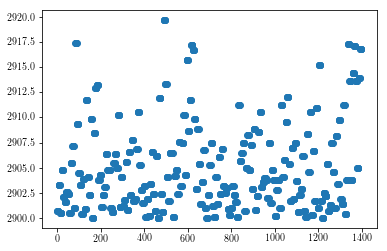

In [466]:
plt.plot(Q_c,'o')

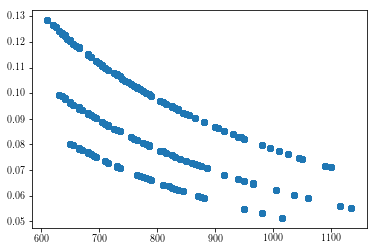

In [357]:
plt.plot(m_f_target,np.array(ECr_c),'o')

for i in range(len(m_f_target)):
    if isnan(W_FT_c[i]) == True:
        print(i)

In [359]:
N_circ_cold = 6
N_circ_hot = 8

W_FT_c = np.zeros(len(m_f_target))
W_Ff_c = np.zeros(len(m_f_target))
W_Fp_c = np.zeros(len(m_f_target))

W_FT_h = np.zeros(len(m_f_target))
W_Ff_h = np.zeros(len(m_f_target))
W_Fp_h = np.zeros(len(m_f_target))


for i in range(len(m_f_target)):
    [W_FT_c[i],W_Ff_c[i],W_Fp_c[i]] = HEx_Power(m_f_HEx_c,W_T_HEx_c,W_f_HEx_c,W_p_HEx_c,Ec_HEx_c,4*m_f_target[i]/N_circ_cold,ECr_c[i])
    [W_FT_h[i],W_Ff_h[i],W_Fp_h[i]] = HEx_Power(m_f_HEx_h,W_T_HEx_h,W_f_HEx_h,W_p_HEx_h,Ec_HEx_h,4*m_f_target[i]/N_circ_hot,ECr_h[i])
    #if W_FT_c[i] == 'Nan':
        #print(4*m_f_target[i]/8,ECr_c[i])
    #if W_FT_c[i] == 'Nan':
        #print(4*m_f_target[i]/8,ECr_h[i])

In [360]:
W_p_valve = (2*np.array(m_f_target)/4/1000)**2*10**5**(2*np.array(m_f_target)/3600)/1000*4/np.array(FE_target)
W_valve   = 8*16

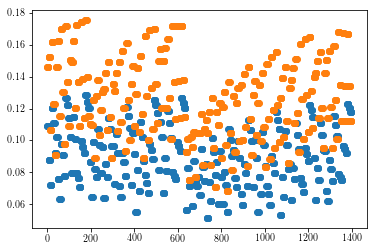

In [361]:
plt.plot(ECr_c,'o')
plt.plot(ECr_h,'o')

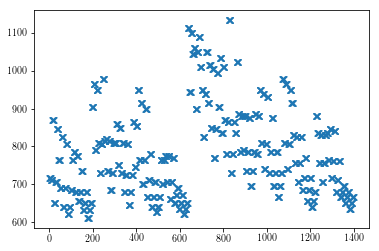

In [362]:
plt.plot(m_f_target,'x')

In [363]:
m_La = 4/np.array(FE_target)*np.array(H_target)*np.array(W_target)*np.array(L_target)*(1-0.55)*7000*10**-9
m_Rt = np.pi*((np.array(R4))**2-np.array(R3)**2)*10**-6*((1+ np.array(L_xt_target))*np.array(L_target)/1000)*7500 #25**2
m_St = np.pi*((np.array(R2)**2))*10**-6*((1+ np.array(L_xt_target))*np.array(L_target)/1000)*7500
m_Fe = np.pi*((np.array(R4)+40)**2-np.array(R4)**2)*10**-6*((1+ np.array(L_xt_target))*np.array(L_target)/1000)*7500 #25**2
m_Nd = m_Rt + m_St + m_Fe
m_w  = (4/np.array(FE_target)*np.array(H_target)*np.array(W_target)*np.array(L_target)*(0.45)*1000*10**-9)

In [364]:
m_T = m_La + m_Rt + m_St + m_Fe + m_w
W_T = W_Ff_c + W_Ff_h + W_Fp_c + W_Fp_h +np.array(W_mag)*4/np.array(FE_target) + np.array(W_pump)*4/np.array(FE_target) + W_valve + W_p_valve

In [476]:
m_p = []
W_pa =[]

m_Nd_p = []
m_La_p = []
m_w_p = []

W_p_CHEx_p = []
W_p_CHEx_f = []
W_p_HHEx_p = []
W_p_HHEx_f = []
W_p_mag = []
W_p_pump = []
W_pa_valve = []
W_pa_p_valve = []


m_f_p = []
FE_p  =[]
f_p = []
L_p = []
H_p = []
W_p = []
B_max_p = []
Tce_p = []
The_p = []

R2_p = []
R3_p = []
R4_p = []
L_xt_p = []


for i in range(len(m_T)):
    #print(i)
    A = 0
    for j in  range(len(m_T)):
        if m_T[i] > m_T[j] and round(W_T[i],2) >= round(W_T[j],2):
            A = 1
    if A == 0 :
        
        
        A = Optimal(m_f_target[i]/3600,0.25,f_target[i],L_target[i],H_target[i],W_target[i],B_target[i],22+273.15,35+273.15,Tce_target[i],The_target[i],L_xt_target[i])
        print(m_T[i],W_T[i],A[0])
        m_p.append(m_T[i])
        m_Nd_p.append(m_Nd[i])
        m_La_p.append(m_La[i])
        m_w_p.append(m_w[i])
        
        m_f_p.append(m_f_target[i])
        FE_p.append(FE_target[i])
        f_p.append(f_target[i])
        L_p.append(L_target[i])
        H_p.append(H_target[i])
        W_p.append(W_target[i])
        B_max_p.append(B_target[i])
        Tce_p.append(Tce_target[i])
        The_p.append(The_target[i])
        
        R2_p.append(R2[i])
        R3_p.append(R3[i])
        R4_p.append(R4[i])
        L_xt_p.append(L_xt_target[i])
        
        
        W_pa.append(W_T[i])
        W_p_CHEx_p.append(W_Fp_c[i])
        W_p_CHEx_f.append(W_Ff_c[i])
        W_p_HHEx_p.append(W_Fp_h[i])
        W_p_HHEx_f.append(W_Ff_h[i])
        W_p_mag.append(np.array(W_mag[i])*4/np.array(FE_target[i]))
        W_p_pump.append(np.array(W_pump[i])*4/np.array(FE_target[i]))
        W_pa_valve.append(W_valve)
        W_pa_p_valve.append(W_p_valve[i])   

642.138861957453 1312.4790925239633 [3141.82182974]
642.138861957453 1014.0341360281254 [2960.44108022]
642.138861957453 1304.8663072276397 [3113.36463297]
599.3485972234614 1466.1822649026083 [3082.39074864]
676.1922565562862 986.5401952503233 [2895.7399012]
630.5942935784649 1426.6708244008755 [2986.64270123]


Text(0,0.5,'Power [W]')

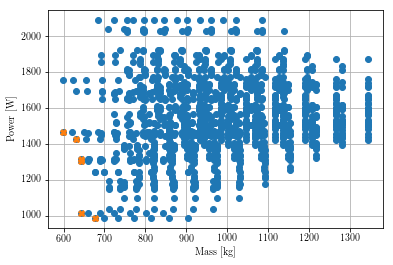

In [458]:
plt.plot(m_T,W_T,'o')
plt.plot(m_p,W_pa,'X')
plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
#plt.savefig('Optimum_2Hz.png',format = 'png', dpi=500,bbox_inches='tight')

In [482]:
f_p,L_p,H_p,W_p,B_max_p

([2.0, 2.0, 2.0, 2.0, 2.0, 2.0],
 [100, 100, 100, 110, 110, 120],
 [50, 50, 50, 50, 50, 50],
 [65, 65, 65, 55, 65, 55],
 [1.2, 1.2, 1.2, 1.2, 1.2, 1.2])

In [483]:
i=2
Optimal(m_f_p[i]/3600,FE_p[i],f_p[i],L_p[i],H_p[i],W_p[i],B_max_p[i],22+273.15,35+273.15,Tce_p[i],The_p[i],L_xt_p[i])

(array([3113.36463297]),
 array([0.00216701]),
 array([-0.00179146]),
 array([475.11498098]),
 array([236.15771343]),
 array([175.95688222]),
 array([-64.46538903]),
 20.443835248836745,
 array([2409.0197724]))

In [486]:
Q_c_new = [[] for i in range(len(m_p))]
m_flow_new = [[] for i in range(len(m_p))]


for i in range(len(m_p)):
    m_flow = np.arange(m_f_p[i],1200,5)
    #print(m_f_p[i])
    for j in range(len(m_flow)):
        A = Optimal(m_flow[j]/3600,FE_p[i],f_p[i],L_p[i],H_p[i],W_p[i],B_max_p[i],22+273.15,35+273.15,Tce_p[i],The_p[i],L_xt_p[i])
        #print(m_flow[j],A[0],i,j,FE_p[i],f_p[i],L_p[i],H_p[i],W_p[i],B_max_p[i],22+273.15,35+273.15,Tce_p[i],The_p[i],L_xt_p[i])
        Q_c_new[i].append(A[0])
        m_flow_new[i].append(m_flow[j])

1115.0 [3141.82182974] 0 0 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1120.0 [3152.68014609] 0 1 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1125.0 [3163.5132764] 0 2 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1130.0 [3174.32116609] 0 3 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1135.0 [3185.1037607] 0 4 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1140.0 [3195.86100591] 0 5 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1145.0 [3206.59284748] 0 6 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1150.0 [3217.29923135] 0 7 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1155.0 [3227.98010353] 0 8 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1160.0 [3238.63541019] 0 9 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1165.0 [3249.26509759] 0 10 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1170.0 [3259.86911213] 0 11 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1175.0 [3270.44740031] 0 12 0.25 2.0 100 50 65 1.2 295.15 308.15 12 43 0.1
1180.0 [3280.99990877] 0 13 0.25 2.0 

1155.0 [3285.024425] 5 29 0.25 2.0 120 50 55 1.2 295.15 308.15 14 43 0.1
1160.0 [3294.7353822] 5 30 0.25 2.0 120 50 55 1.2 295.15 308.15 14 43 0.1
1165.0 [3304.40693379] 5 31 0.25 2.0 120 50 55 1.2 295.15 308.15 14 43 0.1
1170.0 [3314.03899731] 5 32 0.25 2.0 120 50 55 1.2 295.15 308.15 14 43 0.1
1175.0 [3323.63149049] 5 33 0.25 2.0 120 50 55 1.2 295.15 308.15 14 43 0.1
1180.0 [3333.18433124] 5 34 0.25 2.0 120 50 55 1.2 295.15 308.15 14 43 0.1
1185.0 [3342.69743764] 5 35 0.25 2.0 120 50 55 1.2 295.15 308.15 14 43 0.1
1190.0 [3352.17072795] 5 36 0.25 2.0 120 50 55 1.2 295.15 308.15 14 43 0.1
1195.0 [3361.60412061] 5 37 0.25 2.0 120 50 55 1.2 295.15 308.15 14 43 0.1


In [487]:
m_p

[642.138861957453,
 642.138861957453,
 642.138861957453,
 599.3485972234614,
 676.1922565562862,
 630.5942935784649]

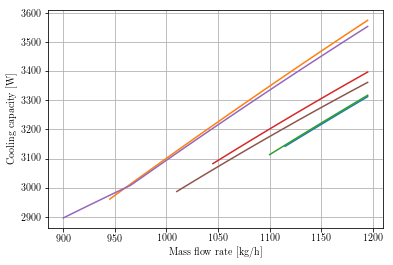

In [490]:
for i in range(len(m_p)):
    plt.plot(m_flow_new[i],Q_c_new[i])
plt.grid()
plt.xlabel('Mass flow rate [kg/h]')
plt.ylabel('Cooling capacity [W]')
plt.savefig('Opt.png',format = 'png', dpi=500,bbox_inches='tight')

In [367]:
m_p,W_pa

([642.138861957453,
  642.138861957453,
  642.138861957453,
  599.3485972234614,
  676.1922565562862,
  630.5942935784649],
 [1312.4790925239633,
  1014.0341360281254,
  1304.8663072276397,
  1466.1822649026083,
  986.5401952503233,
  1426.6708244008755])

In [368]:
m_L180 = m_p
W_L180 = W_pa

In [369]:
plt.plot(m_L140,W_L140,'o', label = 'L = 140 mm')
plt.plot(m_L160,W_L160,'o', label = 'L = 160 mm')
plt.plot(m_L180,W_L180,'o', label = 'W = 180 mm')

plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.legend()
#plt.savefig('Length.png',format = 'png', dpi=500,bbox_inches='tight')

NameError: name 'm_L140' is not defined

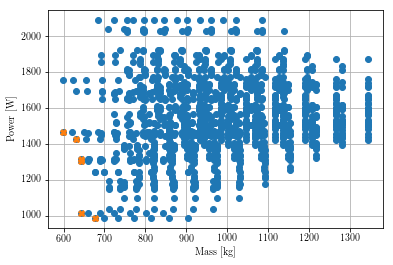

In [370]:
plt.plot(m_T,W_T,'o')
plt.plot(m_p,W_pa,'X')
plt.grid()
#plt.xlim([500,700])
#plt.ylim([1000,2500])
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.savefig('Optimum_zoom_1Hz.png',format = 'png', dpi=500,bbox_inches='tight')

In [371]:
dP_AMR = np.array(W_pump)/(np.array(m_f_target)/3600)*1000

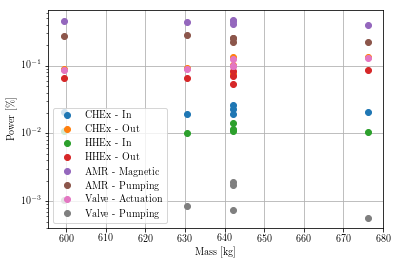

In [372]:
plt.semilogy(m_p,np.array(W_p_CHEx_p)/np.array(W_pa),'o',label = 'CHEx - In')
plt.semilogy(m_p,np.array(W_p_CHEx_f)/np.array(W_pa),'o',label = 'CHEx - Out')
plt.semilogy(m_p,np.array(W_p_HHEx_p)/np.array(W_pa),'o',label = 'HHEx - In')
plt.semilogy(m_p,np.array(W_p_HHEx_f)/np.array(W_pa),'o',label = 'HHEx - Out')
plt.semilogy(m_p,np.array(W_p_mag)/np.array(W_pa),'o',label = 'AMR - Magnetic')
plt.semilogy(m_p,np.array(W_p_pump)/np.array(W_pa),'o',label = 'AMR - Pumping')
plt.semilogy(m_p,np.array(W_pa_valve)/np.array(W_pa),'o',label = 'Valve - Actuation')
plt.semilogy(m_p,np.array(W_pa_p_valve)/np.array(W_pa),'o',label = 'Valve - Pumping')
plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [$\%$]')
plt.legend()
plt.savefig('Power_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [373]:
workbook = xlsxwriter.Workbook('Optimization_results_1Hz.xlsx')
Data = workbook.add_worksheet('Data')

for i in range(len(m_f_p)):
    Data.write(i,0,m_f_p[i]) 
    Data.write(i,1,FE_p[i])
    Data.write(i,2,f_p[i])
    Data.write(i,3,L_p[i])
    Data.write(i,4,H_p[i])
    Data.write(i,5,W_p[i]) 
    Data.write(i,6,B_max_p[i])
    Data.write(i,7,Tce_p[i])
    Data.write(i,8,The_p[i])
    Data.write(i,9,m_p[i])
    Data.write(i,10,m_Nd_p[i])
    Data.write(i,11,m_La_p[i])
    Data.write(i,12,m_w_p[i])
    Data.write(i,13,W_pa[i])
    Data.write(i,14,W_p_CHEx_p[i])
    Data.write(i,15,W_p_CHEx_f[i])
    Data.write(i,16,W_p_HHEx_p[i])
    Data.write(i,17,W_p_HHEx_f[i])
    Data.write(i,18,W_p_mag[i])
    Data.write(i,19,W_p_pump[i])
    Data.write(i,20,R2_p[i])
    Data.write(i,21,R3_p[i])
    Data.write(i,22,R4_p[i])
    

workbook.close()

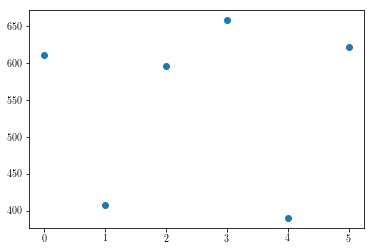

In [374]:
A = W_p_CHEx_f +W_p_CHEx_p
plt.plot(W_p_mag,'o')

In [375]:
W_pa

[1312.4790925239633,
 1014.0341360281254,
 1304.8663072276397,
 1466.1822649026083,
 986.5401952503233,
 1426.6708244008755]

In [376]:
len(W_p_valve)

1400

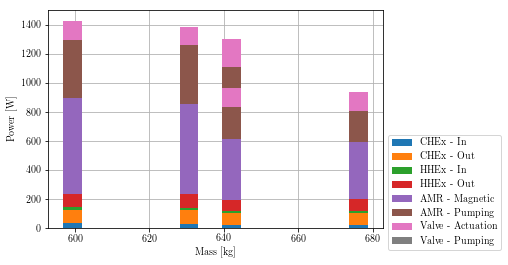

In [377]:
width = 5
plt.grid(zorder = 0)
plt.bar(m_p,W_p_CHEx_p, width, label = 'CHEx - In',zorder = 3)
plt.bar(m_p,W_p_HHEx_f, width, bottom = W_p_CHEx_p, label = 'CHEx - Out',zorder = 3)
plt.bar(m_p,W_p_HHEx_p, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f), label = 'HHEx - In',zorder = 3)
plt.bar(m_p,W_p_HHEx_f, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p), label = 'HHEx - Out',zorder = 3)
plt.bar(m_p,W_p_mag, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f), label = 'AMR - Magnetic',zorder = 3)
plt.bar(m_p,W_p_pump, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f)+ np.array(W_p_mag) , label = 'AMR - Pumping',zorder = 3)
plt.bar(m_p,W_pa_valve, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f) + np.array(W_p_mag) + np.array(W_p_pump) , label = 'Valve - Actuation',zorder = 3)
plt.bar(m_p,W_pa_p_valve, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f)+ np.array(W_p_mag) + np.array(W_p_pump)+ np.array(W_pa_valve), label = 'Valve - Pumping',zorder = 3)

#plt.xlim([575,865])
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.legend(bbox_to_anchor = (1,0.45))
plt.savefig('Power_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [378]:
m_Rt_p = np.pi*((np.array(R4_p))**2-np.array(R3_p)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2
m_St_p = np.pi*((np.array(R2_p)**2))*10**-6*(5/3**np.array(L_p)/1000)*7500
m_Fe_p_10 = np.pi*((np.array(R4_p)+10)**2-np.array(R4_p)**2)*10**-6*(5/3*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_20 = np.pi*((np.array(R4_p)+20)**2-(np.array(R4_p)+10)**2)*10**-6*(5/3*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_40 = np.pi*((np.array(R4_p)+40)**2-(np.array(R4_p)+20)**2)*10**-6*(5/3*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_80 = np.pi*((np.array(R4_p)+80)**2-(np.array(R4_p)+40)**2)*10**-6*(5/3*np.array(L_p)/1000)*7500 #25**2 

[175.9568822244047,
 175.9568822244047,
 175.9568822244047,
 150.82018476377544,
 175.9568822244047,
 150.82018476377544]

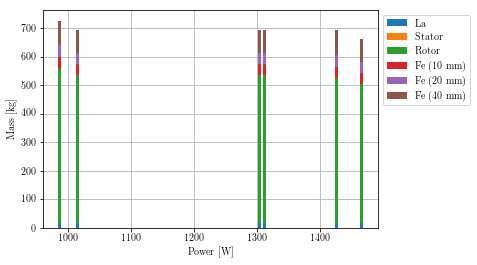

In [379]:
width = 5
plt.grid(zorder = 0)
plt.bar(W_pa,m_La_p, width, label = 'La',zorder = 3)
plt.bar(W_pa,m_St_p, width,bottom = m_La_p, label = 'Stator',zorder = 3)
plt.bar(W_pa,m_Rt_p, width,bottom = np.array(m_La_p) + np.array(m_St_p), label = 'Rotor',zorder = 3)
plt.bar(W_pa,m_Fe_p_10, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p), label = 'Fe (10 mm)',zorder = 3)
plt.bar(W_pa,m_Fe_p_20, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10), label = 'Fe (20 mm)',zorder = 3)
plt.bar(W_pa,m_Fe_p_40, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10)+ np.array(m_Fe_p_20), label = 'Fe (40 mm)',zorder = 3)
#plt.bar(W_pa,m_Fe_p_80, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10)+ np.array(m_Fe_p_20)+ np.array(m_Fe_p_40), label = 'Fe (80 mm)',zorder = 3)
plt.legend( bbox_to_anchor=[1, 1])
plt.ylabel('Mass [kg]')
plt.xlabel('Power [W]')
#plt.xlim(870,1300)
#plt.ylim(0,1050)
plt.savefig('Mass_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [42]:
m_p,W_pa

([628.8416689095038,
  677.5777092234468,
  598.7256878311966,
  631.0020661577161,
  734.0425183254007,
  596.2524914443759,
  628.270048807583,
  733.6486137277545,
  790.5073274273547,
  589.8460156712292,
  621.3799988254984,
  673.1464808652674,
  728.079307105057,
  786.0520861368799,
  846.9721365293085,
  611.154979942932,
  776.6179275787274,
  838.4555585460051,
  903.4369456312623,
  890.8590309551305,
  959.9017547332163,
  943.2625033642558,
  1016.3665638351704],
 [1110.7960597159658,
  1047.1235342853874,
  1242.4065738561055,
  1110.4675051063023,
  1008.5569001584053,
  1246.9260344447873,
  1135.5375914568465,
  1012.6299607421571,
  972.1011863834876,
  1288.5713509382683,
  1174.1098978412676,
  1078.9876055624316,
  1026.0358027711263,
  985.5888151832055,
  943.9901023247666,
  1235.9423728628226,
  999.8065177812388,
  957.3658989853099,
  925.4550951429043,
  936.0709899763563,
  907.4972646697432,
  916.8625093788762,
  888.5572727655237])

In [43]:
len(W_pa)

23

ValueError: x and y must have same first dimension, but have shapes (670,) and (216, 1)

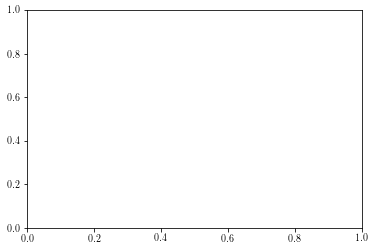

In [44]:
erro_Qc = np.arange(-100,250)
plt.plot(Q_c,np.array(Qc_rg)/16,'o')
plt.plot(erro_Qc,1.1*erro_Qc,'k--')
plt.plot(erro_Qc,0.9*erro_Qc,'k--')
plt.grid()
plt.ylabel('Analytical Cooling Capacity [W]')
plt.xlabel('Numerical Cooling Capacity [W]')
plt.xlim(100,250)
plt.ylim(100,250)
plt.savefig('Qc_fit.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
erro_Qh = np.arange(-100,350)
plt.plot(Q_h,np.array(Qh_rg)/16,'o')
plt.plot(erro_Qh,1.1*erro_Qh,'k--')
plt.plot(erro_Qh,0.9*erro_Qh,'k--')
plt.grid()
plt.ylabel('Analytical Rejected Heat [W]')
plt.xlabel('Numerical Rejected Heat [W]')
plt.xlim(120,300)
plt.ylim(120,300)
plt.savefig('Qh_fit.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
erro_Wp = np.arange(0,25)
plt.plot(W_p,W_pump_rg,'o')

plt.plot(erro_Wp,1.1*erro_Wp,'k--')
plt.plot(erro_Wp,0.9*erro_Wp,'k--')
plt.grid()
plt.ylabel('Analytical Pumping Power [W]')
plt.xlabel('Numerical Pumping Power [W]')
#plt.xlim(120,300)
#plt.ylim(120,300)

### Closure Relations

In [ ]:
plt.plot(N_r,R4,'o')

In [ ]:
plt.plot(H,np.array(R3)-np.array(R2),'o')

Regenerator arranges